In [ ]:
# ─────────────────────────────────────────────────────────────
# 1. Import Required Libraries
# ─────────────────────────────────────────────────────────────
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow import keras

# --- Filter warnings for a cleaner output ---
warnings.filterwarnings("ignore")

In [2]:
# ─────────────────────────────────────────────────────────────
# 2. Configuration Block
# ─────────────────────────────────────────────────────────────
# --- Define file paths ---
# Note: Update this base path to your project's root directory
BASE_PATH = r"d:\GitHub Repos\spray-vision"
DATA_PATH = os.path.join(BASE_PATH, "data", "processed", "preprocessed_dataset.csv")
MODELS_DIR = os.path.join(BASE_PATH, "models")
OUTPUT_DIR = os.path.join(BASE_PATH, "outputs")

# --- Define model and feature names ---
INPUTS = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
TARGETS = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]
RANDOM_STATE = 42

# --- Publication-Ready Plotting Style ---
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Arial',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'savefig.facecolor': 'white',
    'grid.color': '#cccccc',
    'grid.linestyle': '--',
    'grid.linewidth': 0.7,
    'figure.figsize': (16, 12)
})

In [ ]:
# ─────────────────────────────────────────────────────────────
# 3. Data Loading and Preparation Functions
# ─────────────────────────────────────────────────────────────
def load_and_prepare_data(data_path, inputs, targets, test_size=0.2, random_state=42):
    """Loads, renames, and splits the dataset."""
    try:
        raw_df = pd.read_csv(data_path)
    except FileNotFoundError:
        print(f"Error: Data file not found at {data_path}")
        return None, None, None, None, None

    rename_map = {
        "Time_ms": "time", "Pc_bar": "chamb_pressure", "Tc_K": "cham_temp",
        "Pinj_bar": "injection_pres", "rho_kgm3": "density", "mu_Pas": "viscosity",
        "angle_shadow_deg": "angle_shadow", "len_shadow_L_D": "length_shadow",
        "angle_mie_deg": "angle_mie", "len_mie_L_D": "length_mie",
    }
    df = raw_df.rename(columns=rename_map)

    X = df[inputs]
    y = df[targets]
    runs = df["run"] # for stratified split

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=runs
    )

    print("✓ Data loaded and split successfully.")
    print(f"  Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"  Test set shape:     X={X_test.shape}, y={y_test.shape}")

    return df, X_train, X_test, y_train, y_test

In [4]:
# ─────────────────────────────────────────────────────────────
# 4. Model Loading Functions - Scikit-learn Models
# ─────────────────────────────────────────────────────────────
def load_sklearn_models(models_dir):
    """Loads all scikit-learn models from .joblib files."""
    baseline_models = {
        'Linear Regression': 'LinearRegression_regressor.joblib',
        'Decision Tree': 'DecisionTree_regressor.joblib',
        'Random Forest': 'RandomForest_regressor.joblib',
        'Gradient Boosting': 'GradientBoosting_regressor.joblib',
        'SVR': 'SVR_regressor.joblib',
        'KNN': 'KNN_regressor.joblib'
    }
    loaded_models = {}
    print("\nLoading scikit-learn models...")
    for model_name, model_file in baseline_models.items():
        try:
            model_path = os.path.join(models_dir, model_file)
            loaded_models[model_name] = joblib.load(model_path)
            print(f"  ✓ {model_name}")
        except FileNotFoundError:
            print(f"  ✗ {model_name}: Model file not found.")
    return loaded_models

In [ ]:
# ─────────────────────────────────────────────────────────────
# 4. Model Loading Functions - ANN Model
# ─────────────────────────────────────────────────────────────
def load_ann_model(models_dir):
    """Loads the Keras ANN model, handling version compatibility issues."""
    print("\nLoading ANN model...")
    models_to_try = [
        ('ANN_improved_regressor.h5', 'ANN (Improved)'),
        ('ANN_regressor.h5', 'ANN')
    ]
    for model_file, model_name in models_to_try:
        try:
            model_path = os.path.join(models_dir, model_file)
            # Load model without compiling to avoid deserialization errors
            model = keras.models.load_model(model_path, compile=False)
            # Re-compile with a standard optimizer and loss
            model.compile(optimizer='adam', loss='mse')
            print(f"  ✓ {model_name} loaded successfully.")

            # Load corresponding scalers
            input_scaler = joblib.load(os.path.join(models_dir, 'ann_input_scaler.joblib'))
            target_scaler = joblib.load(os.path.join(models_dir, 'ann_target_scaler.joblib'))
            print("  ✓ ANN scalers loaded.")

            return {model_name: model}, input_scaler, target_scaler
        except (OSError, FileNotFoundError):
            print(f"  ! {model_name} or its scalers not found. Trying next...")
        except Exception as e:
            print(f"  ✗ An error occurred loading {model_name}: {e}")

    print("  ✗ All ANN models failed to load.")
    return {}, None, None

In [ ]:
# ─────────────────────────────────────────────────────────────
# 5. Prediction and Evaluation Functions - Generate Predictions
# ─────────────────────────────────────────────────────────────
def generate_predictions(X_test, sklearn_models, ann_model_dict, ann_input_scaler, ann_target_scaler):
    """Generates predictions for all loaded models."""
    predictions = {}

    # Scikit-learn model predictions
    for name, model in sklearn_models.items():
        predictions[name] = model.predict(X_test)

    # ANN model predictions
    if ann_model_dict:
        ann_name, ann_model = list(ann_model_dict.items())[0]
        X_test_scaled = ann_input_scaler.transform(X_test)
        y_pred_scaled = ann_model.predict(X_test_scaled, verbose=0)
        predictions[ann_name] = ann_target_scaler.inverse_transform(y_pred_scaled)

    print(f"\n✓ Predictions generated for {len(predictions)} models.")
    return predictions

In [ ]:
# ─────────────────────────────────────────────────────────────
# 5. Prediction and Evaluation Functions - Evaluate Performance
# ─────────────────────────────────────────────────────────────
def evaluate_performance(y_true, predictions, targets):
    """Calculates R², MAE, and RMSE and returns a summary DataFrame."""
    results = []
    for model_name, y_pred in predictions.items():
        for i, target in enumerate(targets):
            r2 = r2_score(y_true[target], y_pred[:, i])
            mae = mean_absolute_error(y_true[target], y_pred[:, i])
            rmse = np.sqrt(mean_squared_error(y_true[target], y_pred[:, i]))
            results.append({
                'Model': model_name,
                'Target': target,
                'R²': r2,
                'MAE': mae,
                'RMSE': rmse
            })

    # Calculate overall average metrics for each model
    metrics_df = pd.DataFrame(results)
    overall_metrics = metrics_df.groupby('Model')[['R²', 'MAE', 'RMSE']].mean().reset_index()
    overall_metrics['Target'] = 'Overall (Avg)'

    # Combine and sort
    summary_df = pd.concat([metrics_df, overall_metrics]).sort_values(
        by=['Target', 'R²'], ascending=[True, False]
    ).reset_index(drop=True)

    return summary_df

In [ ]:
# ─────────────────────────────────────────────────────────────
# 6. Visualization Function (Publication Quality)
# ─────────────────────────────────────────────────────────────
def plot_true_vs_predicted(y_true, predictions, targets, metrics_df, output_dir):
    """Creates and saves publication-quality True vs. Predicted plots for each target."""
    n_targets = len(targets)
    n_models = len(predictions)

    # Use professional color palette for publication
    colors = plt.cm.Set1(np.linspace(0, 1, n_models))
    model_colors = {model: color for model, color in zip(predictions.keys(), colors)}

    os.makedirs(output_dir, exist_ok=True)

    for i, target in enumerate(targets):
        # Create subplot grid with better layout
        fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(20, 10), facecolor='white')
        axes = axes.flatten()

        # Clean target name for display
        target_display = target.replace('_', ' ').title()
        fig.suptitle(
            f"True vs. Predicted Values: {target_display}",
            fontsize=20,
            fontweight="bold",
            y=0.95
        )

        y_true_target = y_true[target]
        min_val = y_true_target.min()
        max_val = y_true_target.max()

        for j, (model_name, y_pred) in enumerate(predictions.items()):
            ax = axes[j]
            y_pred_target = y_pred[:, i]

            # Update plot range
            min_val = min(min_val, y_pred_target.min())
            max_val = max(max_val, y_pred_target.max())

            # Scatter plot with publication-quality styling
            ax.scatter(
                y_true_target,
                y_pred_target,
                alpha=0.7,
                s=60,
                color=model_colors[model_name],
                edgecolors="black",
                linewidth=0.7,
            )

            # Get metrics for this model and target
            metrics = metrics_df[
                (metrics_df["Model"] == model_name) & (metrics_df["Target"] == target)
            ].iloc[0]
            r2, mae = metrics["R²"], metrics["MAE"]

            # Title with metrics
            ax.set_title(
                f"{model_name}\nR²={r2:.3f} | MAE={mae:.3f}",
                fontsize=14,
                fontweight="bold",
                pad=15
            )

            # Labels and formatting
            ax.set_xlabel("True Values", fontsize=14, fontweight='bold')
            ax.set_ylabel("Predicted Values", fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.5)

        # Finalize and save each target's plot
        range_pad = (max_val - min_val) * 0.05
        for ax in axes[:n_models]:  # Only format used axes
            # Perfect prediction line
            ax.plot(
                [min_val - range_pad, max_val + range_pad],
                [min_val - range_pad, max_val + range_pad],
                "r--",
                linewidth=2,
                alpha=0.8,
                label='Perfect Prediction'
            )
            ax.set_xlim(min_val - range_pad, max_val + range_pad)
            ax.set_ylim(min_val - range_pad, max_val + range_pad)
            ax.set_aspect("equal")
            ax.legend(loc='upper left', frameon=True, fontsize=13)

        # Hide unused subplots
        for k in range(n_models, len(axes)):
            axes[k].set_visible(False)

        # Ensure white background
        fig.patch.set_facecolor('white')

        plt.tight_layout(rect=[0, 0.03, 1, 0.92])

        # Save with high resolution and white background
        plot_filename = os.path.join(output_dir, f"true_vs_predicted_{target}.png")
        plt.savefig(plot_filename, dpi=600, bbox_inches="tight", facecolor='white')
        print(f"  ✓ Plot saved to: {plot_filename}")
        plt.show()

In [ ]:
# ─────────────────────────────────────────────────────────────
# 6b. Comprehensive Visualization Function (All Models & Targets)
# ─────────────────────────────────────────────────────────────
def create_comprehensive_plot(y_true, predictions, targets, output_dir, figsize=(24, 20)):
    """
    Create a comprehensive true vs predicted plot for all models and all targets.
    Publication-ready: plain background, grid, readable fonts, uniform legend.
    """
    n_targets = len(targets)
    n_models = len(predictions)

    # Create subplots - one row per target variable, one column per model + one for combined
    fig, axes = plt.subplots(n_targets, n_models + 1, figsize=figsize, facecolor='white')

    # Handle single row case
    if n_targets == 1:
        axes = axes.reshape(1, -1)

    # Define colors for each model
    colors = plt.cm.Set1(np.linspace(0, 1, n_models))
    model_colors = dict(zip(predictions.keys(), colors))

    # Plot for each target variable
    for target_idx, target_name in enumerate(targets):
        y_true_target = y_true[target_name].values

        # Calculate overall min and max for consistent scaling
        all_values = [y_true_target]
        for model_name, y_pred in predictions.items():
            all_values.append(y_pred[:, target_idx])

        min_val = min(np.min(vals) for vals in all_values)
        max_val = max(np.max(vals) for vals in all_values)

        # Add some padding
        range_pad = (max_val - min_val) * 0.05
        plot_min = min_val - range_pad
        plot_max = max_val + range_pad

        # Plot individual model results
        for model_idx, (model_name, y_pred) in enumerate(predictions.items()):
            ax = axes[target_idx, model_idx]
            y_pred_target = y_pred[:, target_idx]

            # Scatter plot
            ax.scatter(y_true_target, y_pred_target,
                      alpha=0.7, s=60, color=model_colors[model_name],
                      edgecolors='black', linewidth=0.7)

            # Perfect prediction line (45-degree line)
            ax.plot([plot_min, plot_max], [plot_min, plot_max],
                   'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')

            # Calculate and display metrics
            from sklearn.metrics import mean_absolute_error, r2_score
            r2 = r2_score(y_true_target, y_pred_target)
            mae = mean_absolute_error(y_true_target, y_pred_target)

            # Set labels and title
            ax.set_xlabel('True Values')
            ax.set_ylabel('Predicted Values')
            target_display = target_name.replace('_', ' ').title()
            ax.set_title(f'{model_name}\\n{target_display}\\nR²={r2:.3f}, MAE={mae:.3f}',
                        fontweight='bold')

            # Set equal aspect ratio and limits
            ax.set_xlim(plot_min, plot_max)
            ax.set_ylim(plot_min, plot_max)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.5)
            ax.legend(loc='upper left', frameon=True, fontsize=13)

        # Combined plot for all models (last column)
        ax_combined = axes[target_idx, -1]

        for model_name, y_pred in predictions.items():
            y_pred_target = y_pred[:, target_idx]

            # Scatter plot with different colors for each model
            ax_combined.scatter(y_true_target, y_pred_target,
                              alpha=0.7, s=50, color=model_colors[model_name],
                              label=model_name, edgecolors='black', linewidth=0.5)

        # Perfect prediction line
        ax_combined.plot([plot_min, plot_max], [plot_min, plot_max],
                        'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')

        # Set labels and title for combined plot
        ax_combined.set_xlabel('True Values')
        ax_combined.set_ylabel('Predicted Values')
        target_display = target_name.replace('_', ' ').title()
        ax_combined.set_title(f'All Models - {target_display}', fontweight='bold')

        # Set equal aspect ratio and limits
        ax_combined.set_xlim(plot_min, plot_max)
        ax_combined.set_ylim(plot_min, plot_max)
        ax_combined.set_aspect('equal')
        ax_combined.grid(True, alpha=0.5)
        ax_combined.legend(loc='upper left', frameon=True, fontsize=13)

    # Add main title
    fig.suptitle('True vs Predicted Values - All Models and Target Variables',
                 fontsize=18, fontweight='bold', y=0.98)

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.patch.set_facecolor('white')

    # Save comprehensive plot
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, "comprehensive_true_vs_predicted_all_models.png")
    fig.savefig(plot_filename, dpi=600, bbox_inches='tight', facecolor='white')
    print(f"✓ Comprehensive plot saved to: {plot_filename}")

    return fig

In [10]:
# ─────────────────────────────────────────────────────────────
# 7. Main Execution Block - Load Data
# ─────────────────────────────────────────────────────────────
# --- Load Data ---
full_df, X_train, X_test, y_train, y_test = load_and_prepare_data(DATA_PATH, INPUTS, TARGETS, random_state=RANDOM_STATE)

✓ Data loaded and split successfully.
  Training set shape: X=(580, 6), y=(580, 4)
  Test set shape:     X=(146, 6), y=(146, 4)


In [11]:
# ─────────────────────────────────────────────────────────────
# 7. Main Execution Block - Load Models
# ─────────────────────────────────────────────────────────────
# --- Load Models ---
sklearn_models = load_sklearn_models(MODELS_DIR)
ann_model_dict, ann_input_scaler, ann_target_scaler = load_ann_model(MODELS_DIR)


Loading scikit-learn models...
  ✓ Linear Regression
  ✓ Linear Regression
  ✓ Decision Tree
  ✓ Decision Tree
  ✓ Random Forest
  ✓ Gradient Boosting
  ✓ SVR
  ✓ KNN

Loading ANN model...
  ✓ Random Forest
  ✓ Gradient Boosting
  ✓ SVR
  ✓ KNN

Loading ANN model...
  ✓ ANN (Improved) loaded successfully.
  ✓ ANN scalers loaded.
  ✓ ANN (Improved) loaded successfully.
  ✓ ANN scalers loaded.


In [12]:
# ─────────────────────────────────────────────────────────────
# 7. Main Execution Block - Generate Predictions
# ─────────────────────────────────────────────────────────────
# --- Generate Predictions ---
all_predictions = generate_predictions(
    X_test, sklearn_models, ann_model_dict, ann_input_scaler, ann_target_scaler
)


✓ Predictions generated for 7 models.


In [13]:
# ─────────────────────────────────────────────────────────────
# 7. Main Execution Block - Evaluate Performance and Display Results
# ─────────────────────────────────────────────────────────────
# --- Evaluate Performance ---
if all_predictions:
    metrics_summary_df = evaluate_performance(y_test, all_predictions, TARGETS)

    print("\n" + "="*80)
    print("MODEL PERFORMANCE SUMMARY (Sorted by Overall R²)")
    print("="*80)

    # Display overall results sorted by R²
    overall_df = metrics_summary_df[metrics_summary_df['Target'] == 'Overall (Avg)'].sort_values('R²', ascending=False)
    print(overall_df.to_string(index=False))

    # Save metrics to CSV
    metrics_filename = os.path.join(OUTPUT_DIR, "detailed_model_metrics.csv")
    metrics_summary_df.to_csv(metrics_filename, index=False)
    print(f"\n✓ Detailed metrics saved to: {metrics_filename}")
else:
    print("\n⚠️ No predictions were generated. Cannot evaluate performance.")


MODEL PERFORMANCE SUMMARY (Sorted by Overall R²)
            Model        Target       R²      MAE     RMSE
              KNN Overall (Avg) 0.998793 0.740588 1.065823
Gradient Boosting Overall (Avg) 0.994857 0.481215 0.682400
    Decision Tree Overall (Avg) 0.993631 1.106807 1.496508
   ANN (Improved) Overall (Avg) 0.990369 1.677577 2.319896
              SVR Overall (Avg) 0.988317 1.292134 2.986750
    Random Forest Overall (Avg) 0.982989 2.207117 3.301440
Linear Regression Overall (Avg) 0.834075 4.779483 6.564127

✓ Detailed metrics saved to: d:\GitHub Repos\spray-vision\outputs\detailed_model_metrics.csv



Generating and saving publication-quality plots...
  ✓ Plot saved to: d:\GitHub Repos\spray-vision\outputs\true_vs_predicted_angle_mie.png
  ✓ Plot saved to: d:\GitHub Repos\spray-vision\outputs\true_vs_predicted_angle_mie.png


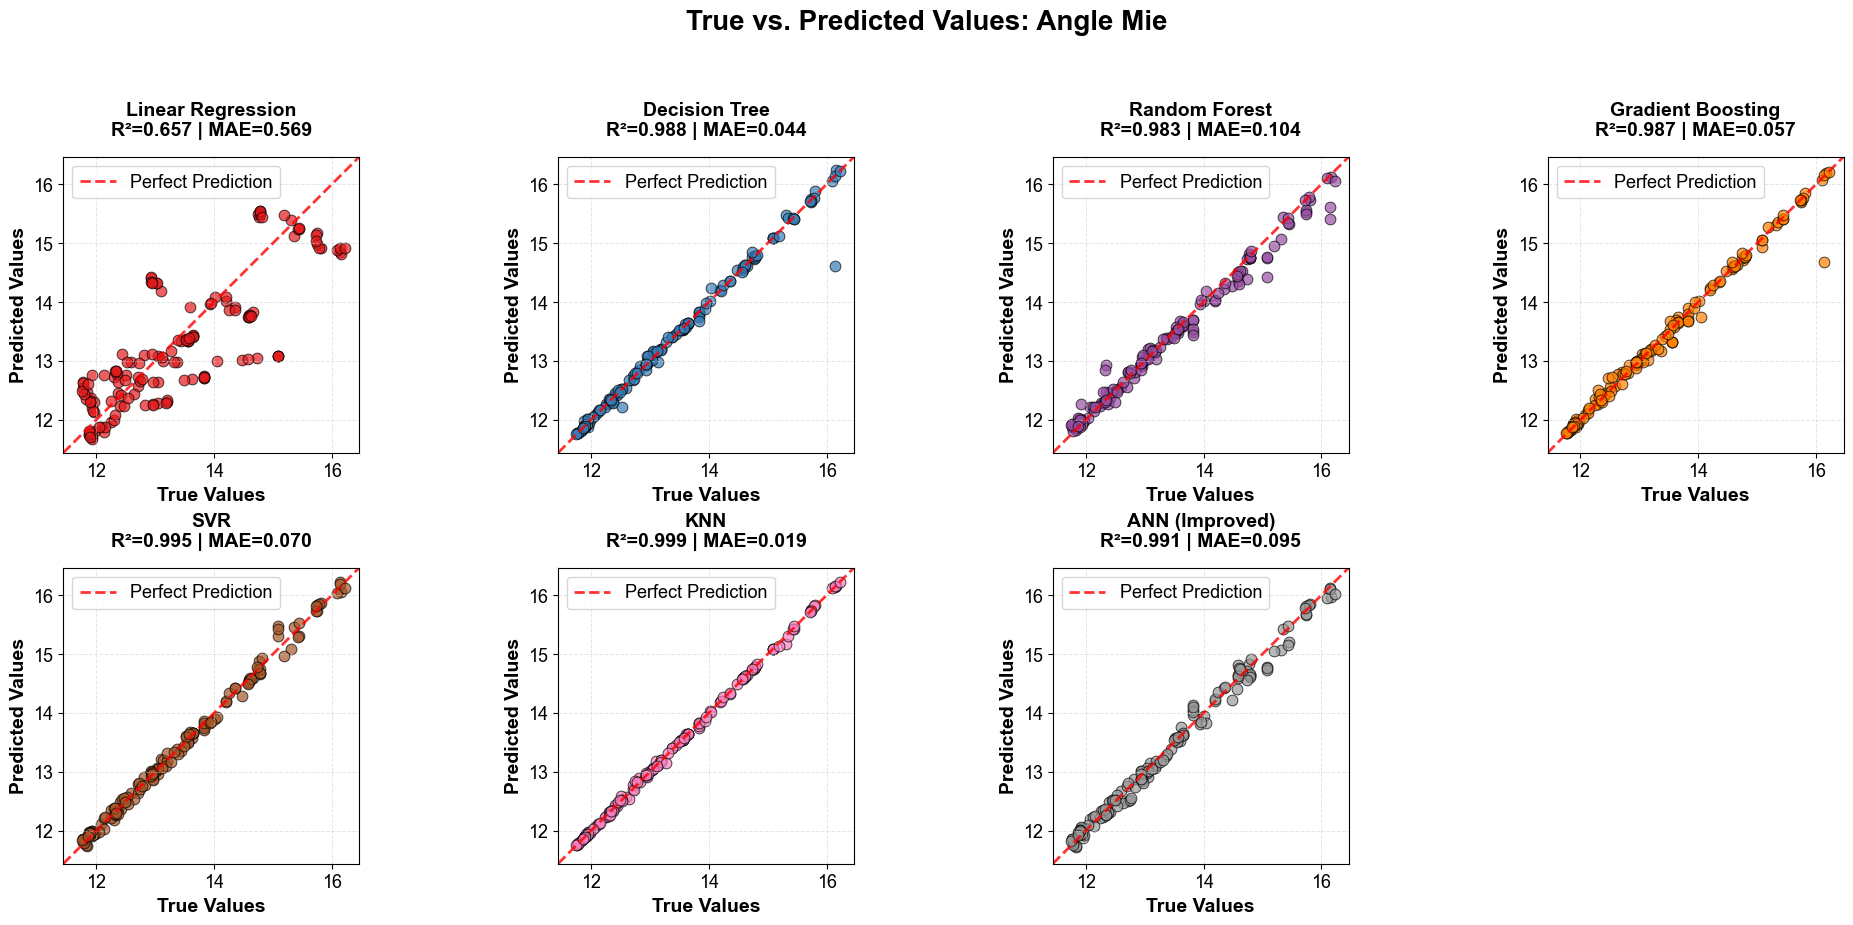

  ✓ Plot saved to: d:\GitHub Repos\spray-vision\outputs\true_vs_predicted_length_mie.png


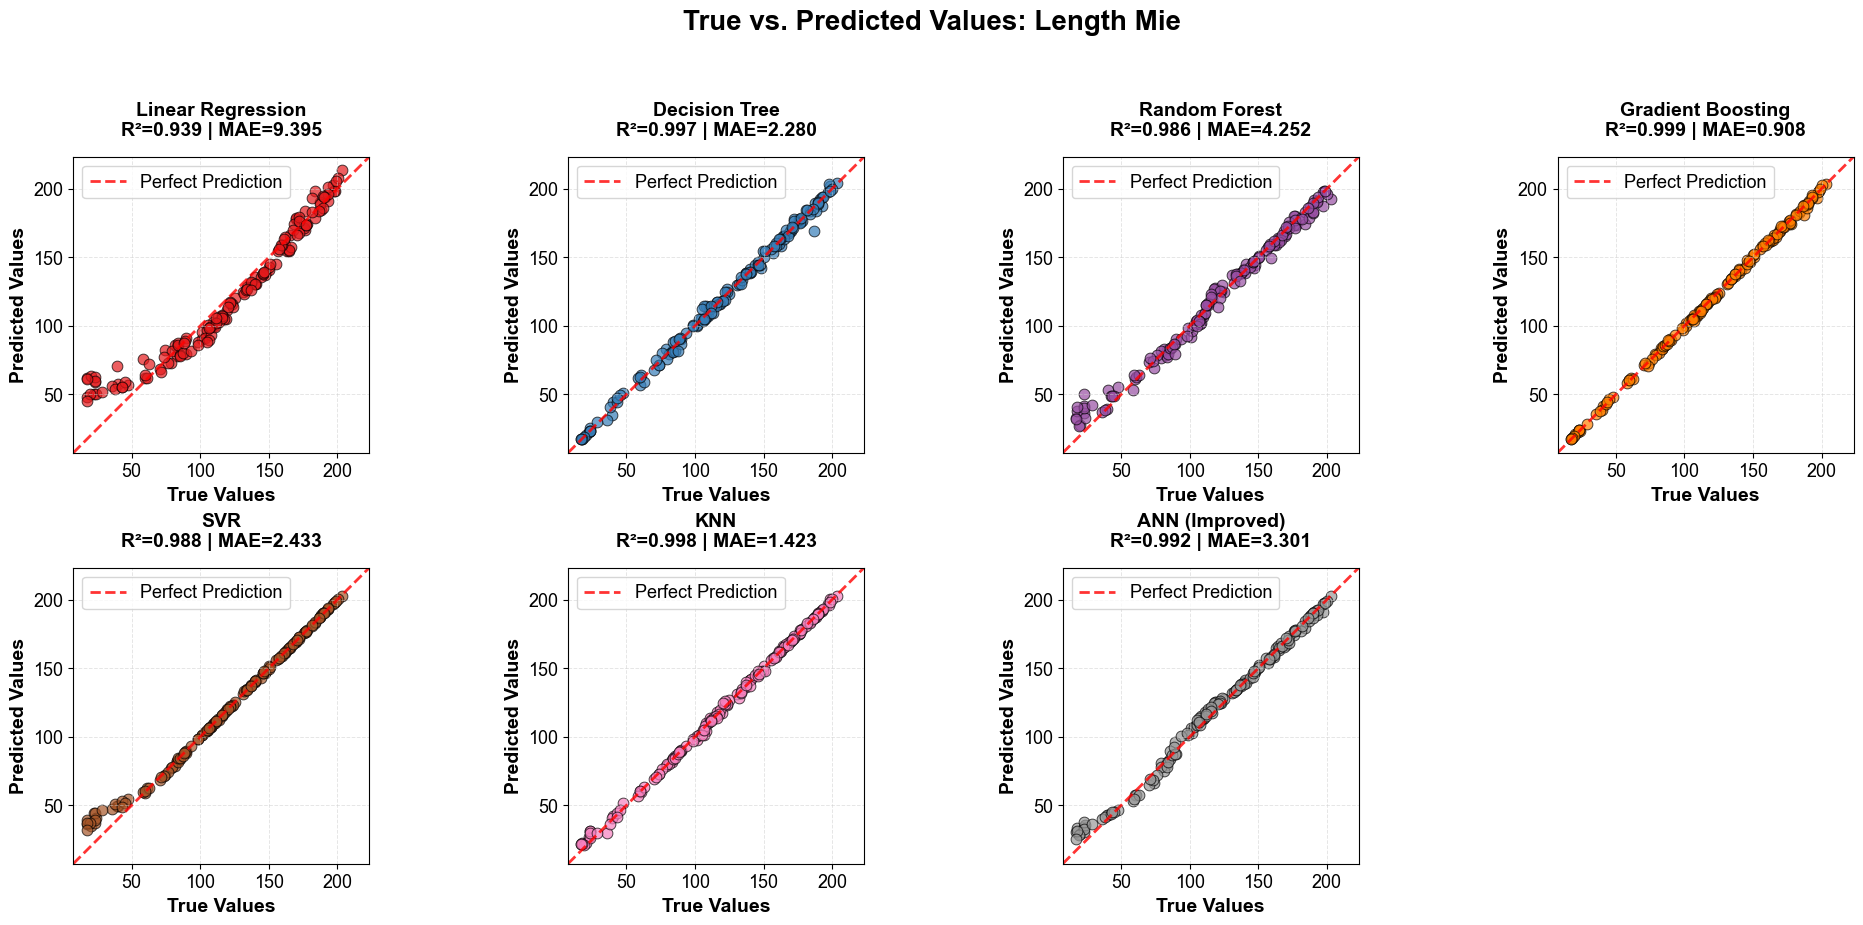

  ✓ Plot saved to: d:\GitHub Repos\spray-vision\outputs\true_vs_predicted_angle_shadow.png


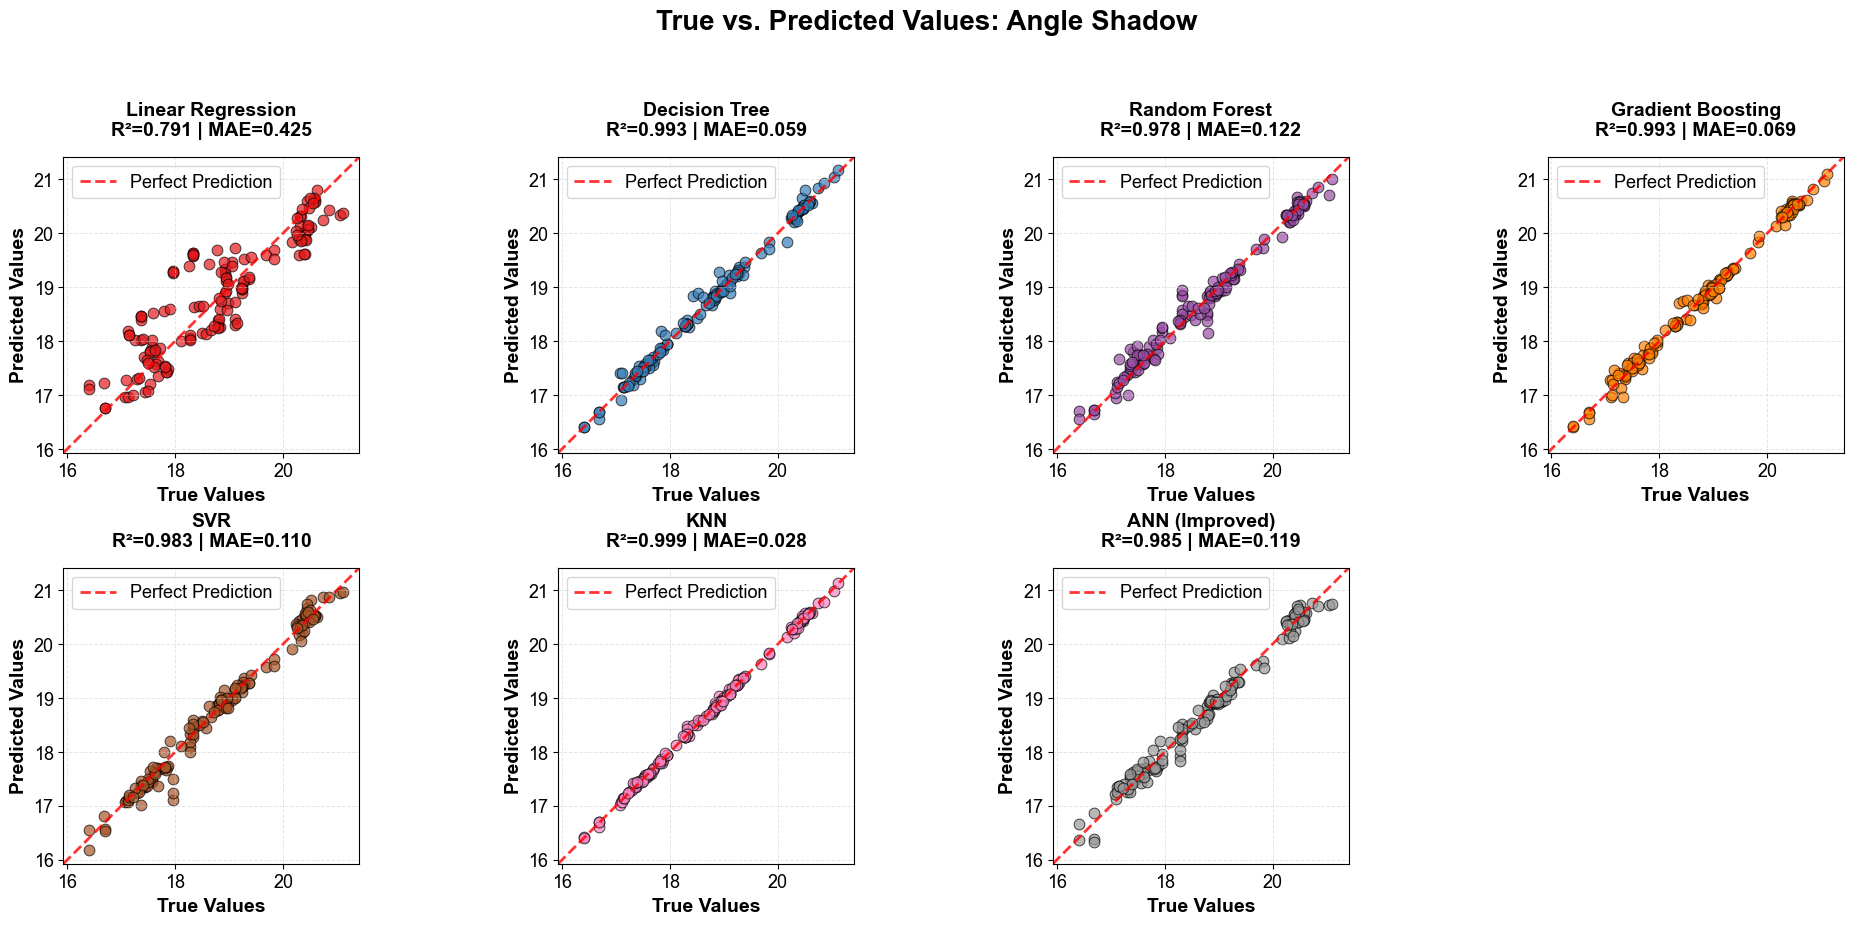

  ✓ Plot saved to: d:\GitHub Repos\spray-vision\outputs\true_vs_predicted_length_shadow.png


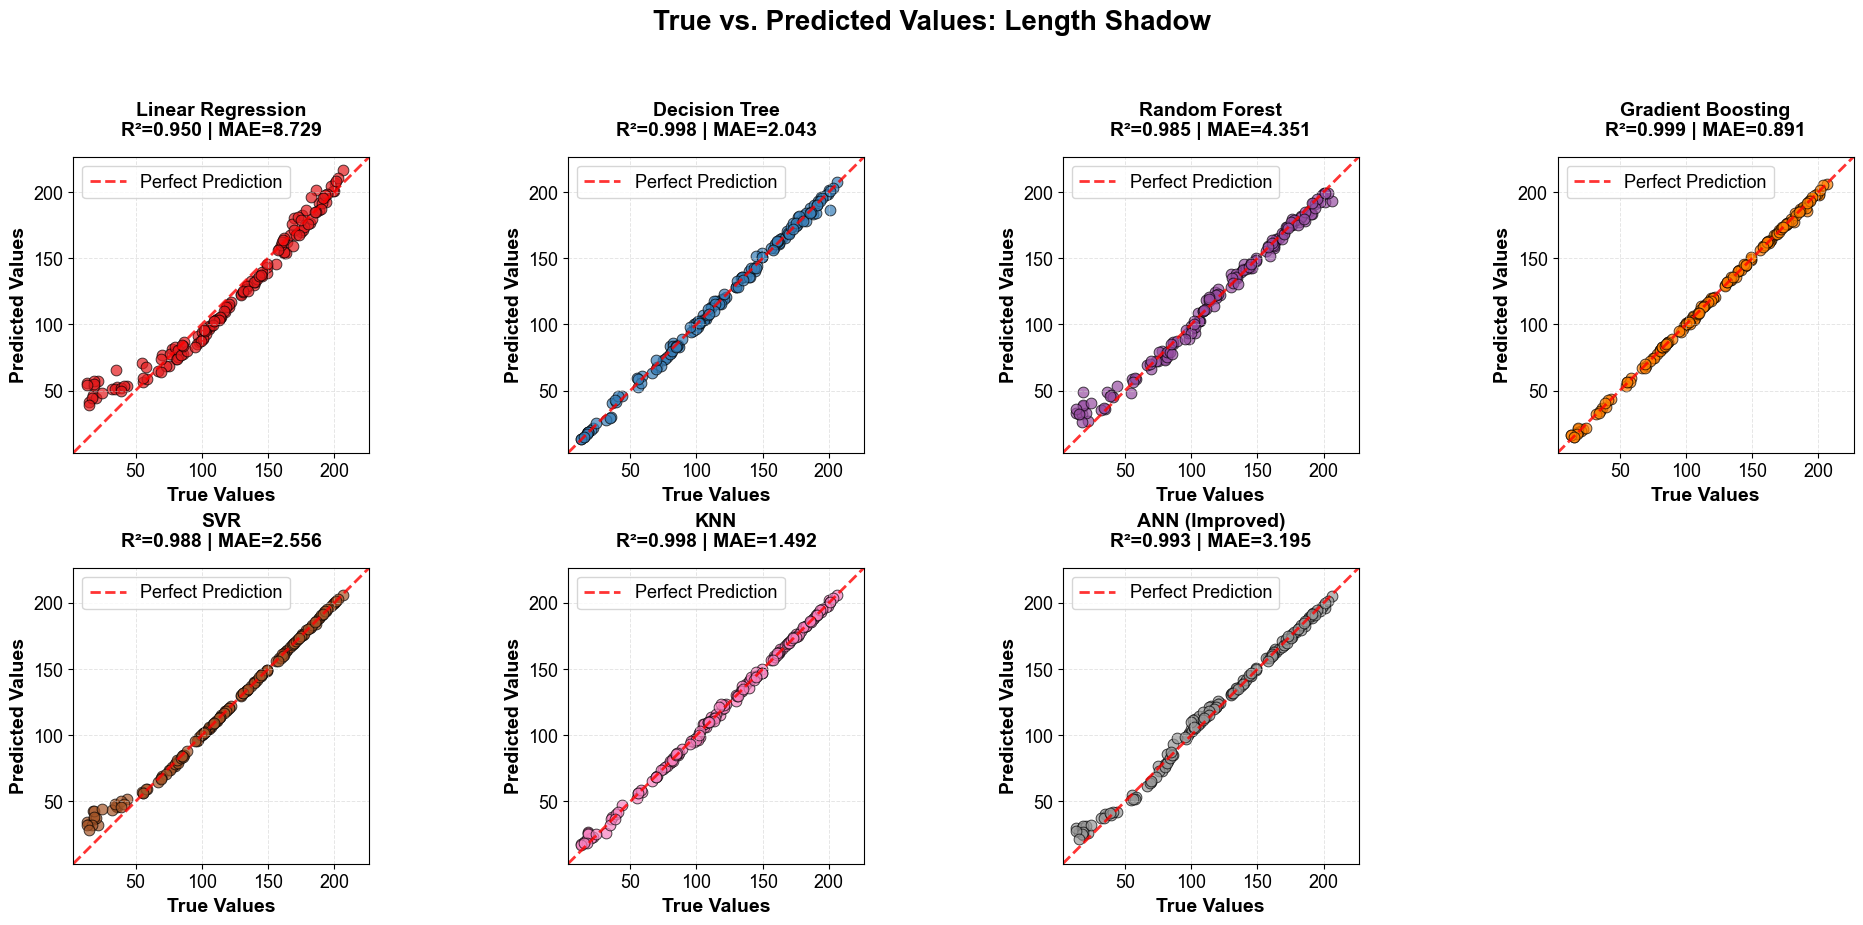


Creating comprehensive plot...
✓ Comprehensive plot saved to: d:\GitHub Repos\spray-vision\outputs\comprehensive_true_vs_predicted_all_models.png
✓ Comprehensive plot saved to: d:\GitHub Repos\spray-vision\outputs\comprehensive_true_vs_predicted_all_models.png


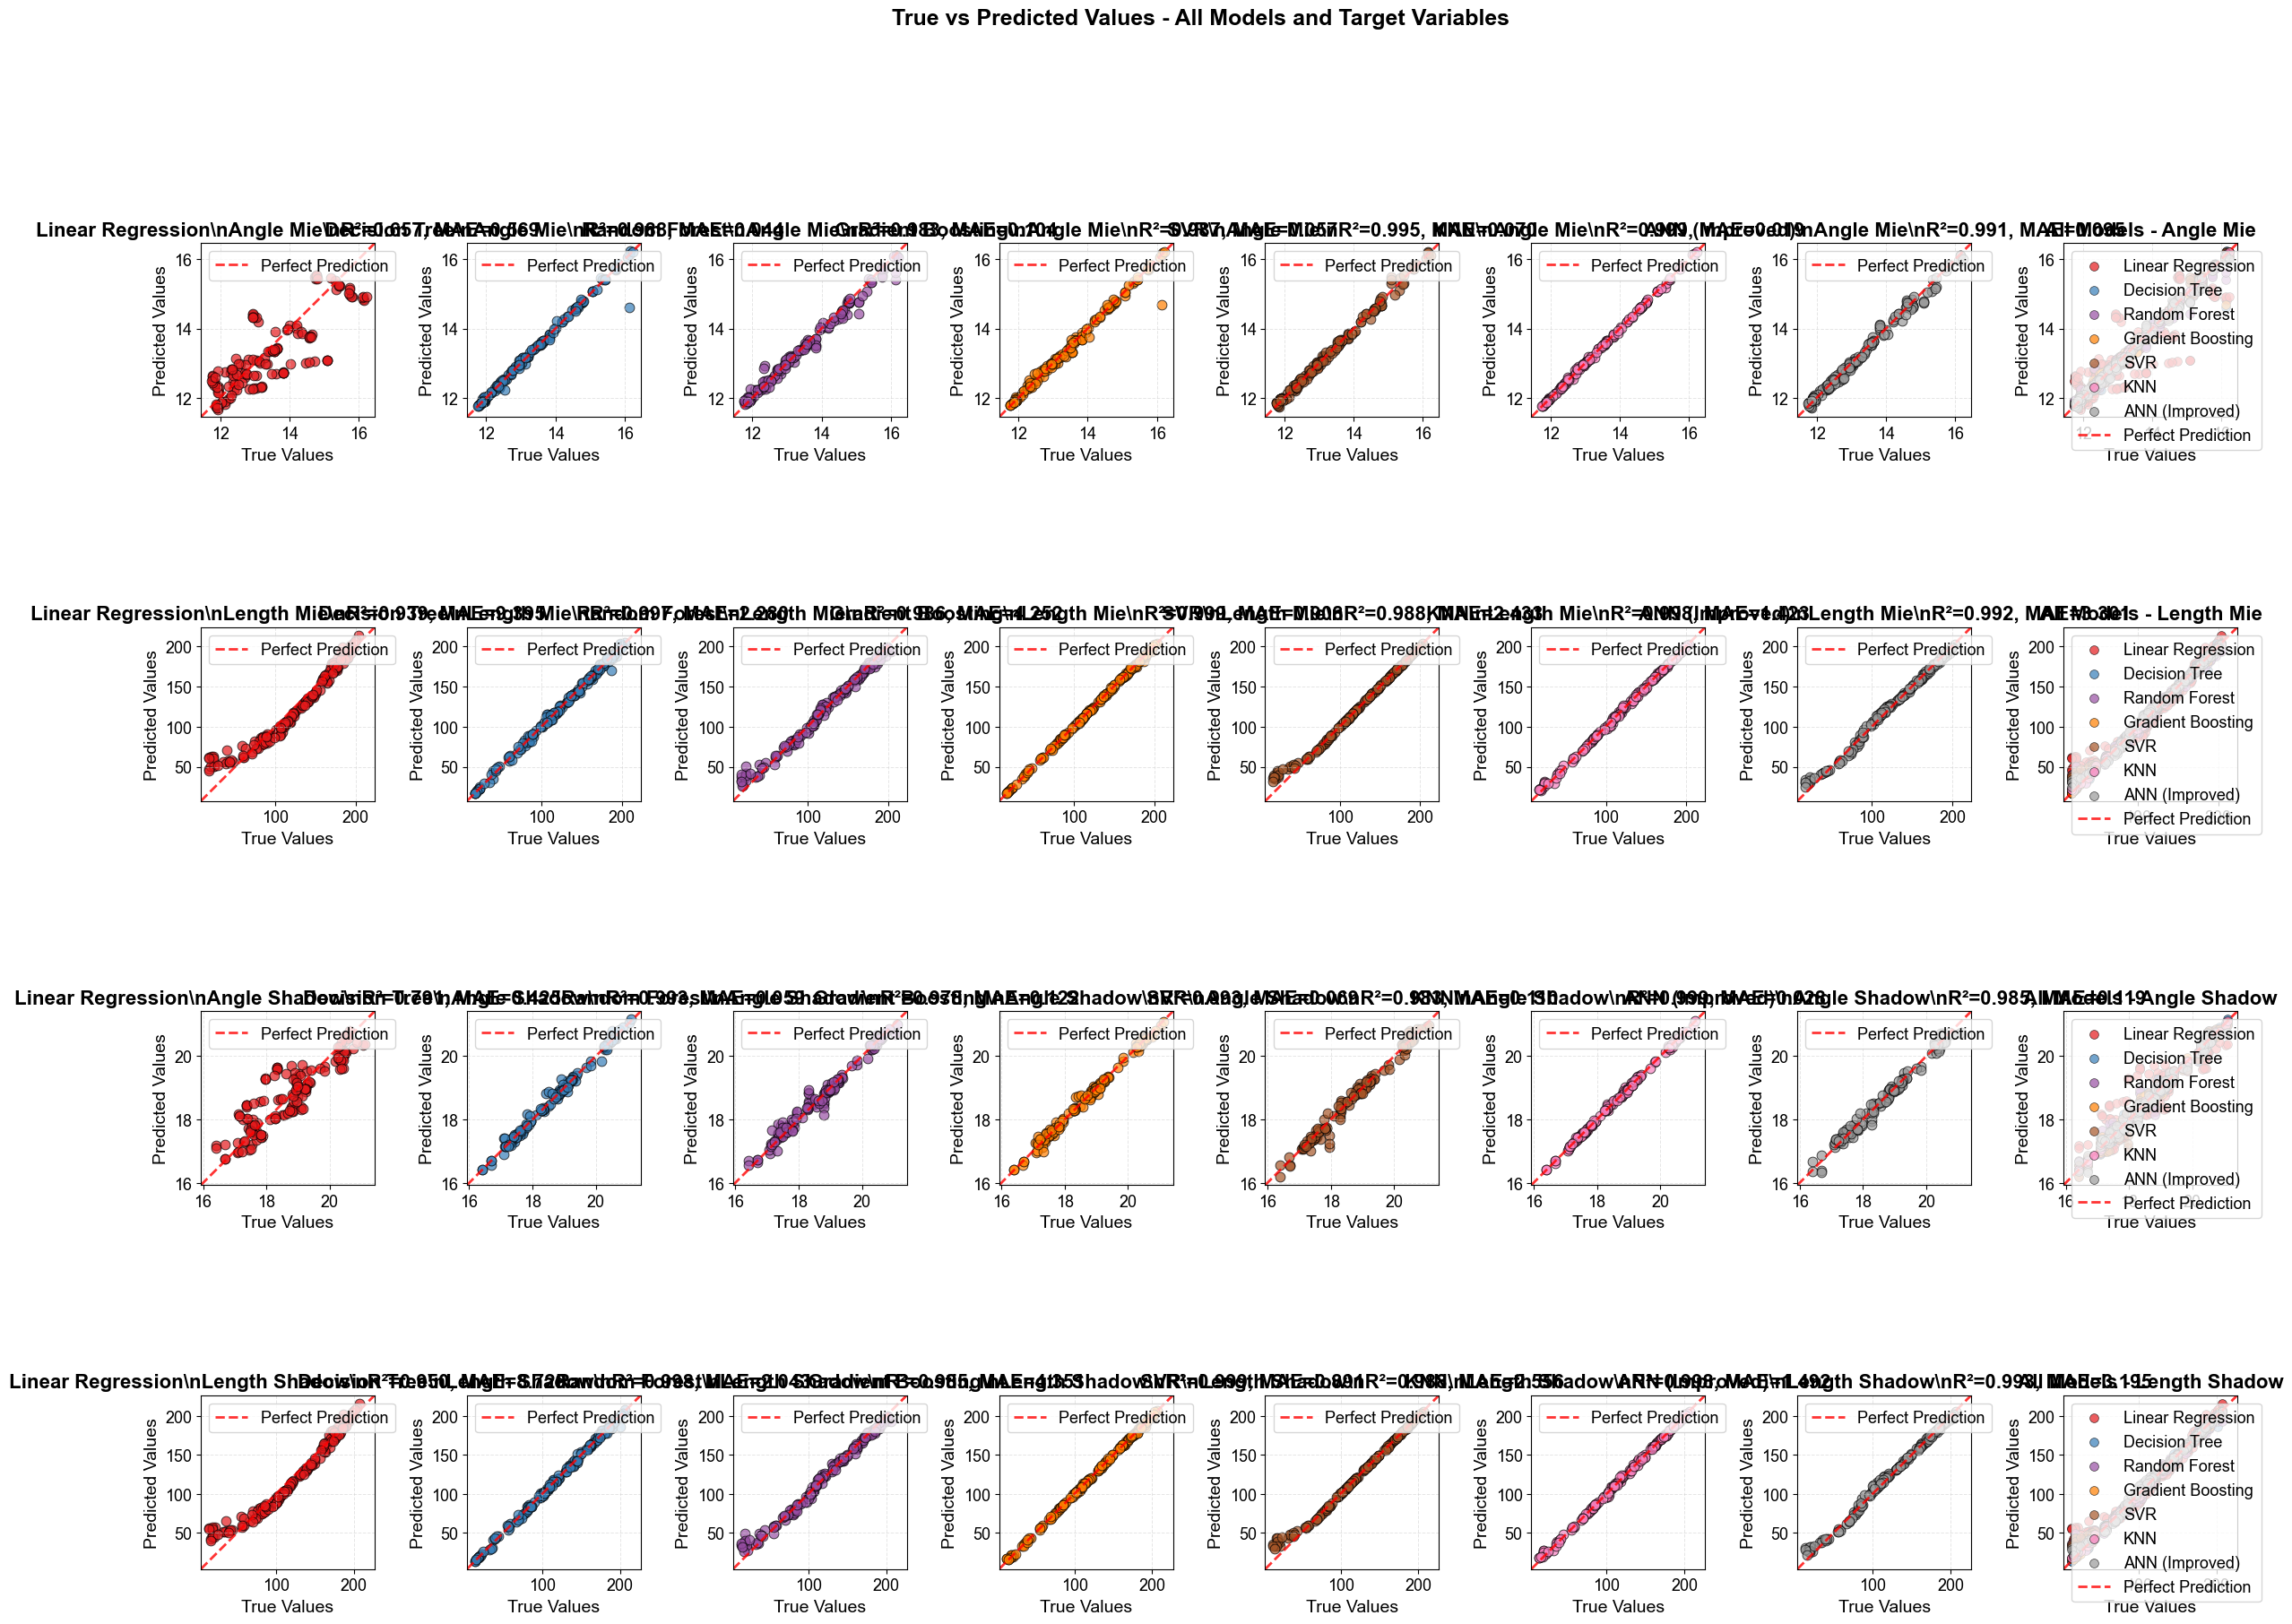


✅ Analysis complete! All plots saved with publication-quality formatting.
Features applied:
  • White background for clean appearance
  • Grid lines for better readability
  • Consistent Arial font family
  • High-resolution output (600 DPI)
  • Uniform legend and axis styling


In [14]:
# ─────────────────────────────────────────────────────────────
# 7. Main Execution Block - Create and Save Visualizations
# ─────────────────────────────────────────────────────────────
# --- Create and Save Visualizations ---
if all_predictions:
    print("\nGenerating and saving publication-quality plots...")

    # Individual plots for each target
    plot_true_vs_predicted(y_test, all_predictions, TARGETS, metrics_summary_df, OUTPUT_DIR)

    # Comprehensive plot showing all models and targets together
    print("\nCreating comprehensive plot...")
    comprehensive_fig = create_comprehensive_plot(y_test, all_predictions, TARGETS, OUTPUT_DIR)
    plt.show()

    print("\n✅ Analysis complete! All plots saved with publication-quality formatting.")
    print("Features applied:")
    print("  • White background for clean appearance")
    print("  • Grid lines for better readability")
    print("  • Consistent Arial font family")
    print("  • High-resolution output (600 DPI)")
    print("  • Uniform legend and axis styling")
else:
    print("\n⚠️ No models were loaded. Cannot generate predictions or plots.")